In [13]:
import torch
import numpy as np
import pandas as pd
from torchvision.transforms import PILToTensor
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from preprocessing import preprocess_image


# This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [2]:
INP_SIZE = (128, 128)
SAMPLE_SIZE = 10000
N_WORKERS = 4
BATCH_SIZE = 256

DATADIR = Path("data")
TENSORED_DATADIR = Path(f'tensored_data_{INP_SIZE[0]}')

In [54]:
class RawDataset(Dataset):
    def __init__(self, datadir, df=None):
        super().__init__()
        self.paths = list(Path(datadir).rglob("*.*"))
        if df is not None:
            self.idtoinchi_dict = {
                _id:_inchi for _id, _inchi in
                zip(df["image_id"].values.tolist(), df["InChI"].values.tolist())
            }
        if len(self.paths) == 0:
            print("No paths found.")
        self.piltotensor = PILToTensor()
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        imgpath = self.paths[idx]
        imgid = imgpath.stem
        img = preprocess_image(imgpath, out_size=INP_SIZE)
        img = torch.from_numpy(np.array(img))
        if hasattr(self, "idtoinchi_dict"):
            target = self.idtoinchi_dict[imgid]
            return img, target
        return img, "test_placeholder"

In [55]:
%%time

df = pd.read_csv("data/train_labels.csv")
trainset = RawDataset(DATADIR/"bms-molecular-translation/train", df)
testset = RawDataset(DATADIR/"bms-molecular-translation/test")
len(trainset), len(testset)

CPU times: user 30.3 s, sys: 2.91 s, total: 33.2 s
Wall time: 49.6 s


(2424186, 1616107)

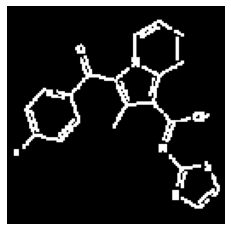

In [56]:
plt.imshow(trainset[50][0], cmap='gray')
plt.axis("off");

In [57]:
trainloader = DataLoader(trainset, BATCH_SIZE, num_workers=N_WORKERS)
testloader  = DataLoader(testset,  BATCH_SIZE, num_workers=N_WORKERS)

In [7]:
for batch in testloader:
    print(batch[0].shape, batch[0].dtype)
    torch.save(batch[0], "test.pt")
    np.save("test.npy", batch[0].detach().numpy())
    break

torch.Size([256, 128, 128]) torch.uint8


In [8]:
fs = 4.2
f"{((2424170/BATCH_SIZE) * fs) / 1024:.3f} GB"

'38.839 GB'

In [41]:
%%time

imgs, imgids = next(iter(trainloader))
print(imgs.shape)

torch.Size([256, 128, 128])
CPU times: user 23.6 ms, sys: 188 ms, total: 212 ms
Wall time: 46.4 s


In [59]:
%%time

imgs, imgids = next(iter(trainloader))
print(imgs.shape)

torch.Size([256, 128, 128])
CPU times: user 14.1 ms, sys: 247 ms, total: 262 ms
Wall time: 3.71 s
